<a href="https://colab.research.google.com/github/dwahast/Deep-learning/blob/master/MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons
- Link útil (https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c)

In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F # softmax

#import pandas as pd # organize files 


In [0]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 169910272/170498071 [00:30<00:00, 10638667.43it/s]

Files already downloaded and verified


In [0]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, shuffle=False)
print(len(test_loader))

10000


In [0]:
# Definir a arquitetura MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
        self.activation_function = nn.Sigmoid()
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x
# Arquitecture with RELU      
class MLP_relu(nn.Module):
    def __init__(self):
        super(MLP_relu, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x),dim =1)
        return x
      
# New Arquitecture with RELU   
class MLP_Srelu(nn.Module):
    def __init__(self):
        super(MLP_Srelu, self).__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim =1)
        return x   


In [0]:
model_std = MLP()
model_relu = MLP_relu()
model_Srelu = MLP_Srelu()
#print(model)

In [0]:
# Definir otimizador e loss
# Nota: testar outros otimizadores e funções de loss (em particular cross entropy)

def optimizer_set(model,optimizer_method, learning_rate):
  if optimizer_method == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adadelta":
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adamax":
    optimizer = torch.optim.Adamax(model.parameters(), lr = learning_rate)
  elif optimizer_method == "rms":
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
  return optimizer

def loss_function_set(loss_function):
  if loss_function == "mse":
    loss_fn = torch.nn.MSELoss()
  elif loss_function == "nllos":
     loss_fn = torch.nn.NLLoss()
  elif loss_function == "cross":
     loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn
  

In [0]:
def one_hot(label, output_size):
    
    label_select = np.zeros(output_size)
    label_select[label]=1
    
    return torch.Tensor(label_select)

In [0]:
def evaluate(model, loss_function, dataset):
  model.eval() # set model to Evaluate "mode"
 # losses = []
  corrects = 0
  current_total = 0
  accuracies = 0
  
 # loss_fn = loss_function_set(loss_function)
  
  for image, label in dataset:
    outputs = model(image)
    
   # if(loss_function == 'mse'):
   #   label_target = one_hot(label,10) # one_hot to set the training class in the escalar
   #   loss = loss_fn(outputs,label_target)
   # else:
   #   loss = loss_fn(outputs,label)
      
   # losses.append(loss.item())
    
    _, predicted = torch.max(outputs.data, 1)
    
    if(predicted==label):
      corrects += 1
    
    current_total += 1
  
  accuracy = corrects/current_total

  return accuracy #, np.mean(losses)
      

#Training function

In [0]:
# Realizar o treinamento aqui
def fit(model, epochs, optimizer_method, loss_function, learning_rate):
  
  print("Opt Method:", optimizer_method.upper(), "| Loss Function:", loss_function.upper(), "| Learning Rate:", learning_rate)
  optimizer = optimizer_set(model,optimizer_method, learning_rate) #optimizer and Learning rate setter
  loss_fn = loss_function_set(loss_function) 
  accuracies = []
  losses = []
  train_acc = []
  for epoch in range(epochs):
    model.train() # Set model to TRAIN "mode" (can be set to False for Test)
    epoch_losses = []
    for image,label in train_loader:
      optimizer.zero_grad()  # cleaning gradients between mini batches
      outputs = model(image) 
     
      if(loss_function == 'mse'):
        label_target = one_hot(label,10) # one_hot to set the training class in the escalar
        loss = loss_fn(outputs,label_target)
      else: 
        loss = loss_fn(outputs, label)
        
      loss.backward() # Backpropagation 
      optimizer.step() # Optimization Method
      
      epoch_losses.append(loss.item())

    losses.append(np.mean(epoch_losses)) # Append mean losses for each epoch
   
    
    acc = evaluate(model, loss_function, train_loader)
    train_acc.append(acc)
    acc = evaluate(model, loss_function, test_loader) #evaluate
    accuracies.append(acc)
    
    #if(epoch%10==0):
    print("Epoch:",epoch, "- Average loss:", np.mean(epoch_losses),"- Accuracy:", acc) # Print mean Loss for each epoch
 
  return {
      "Model": outputs,
      "Acc": accuracies,
      "Train Acc": train_acc,
      "Loss": losses,
      "Name": optimizer_method + " | " + loss_function + " | " + str(learning_rate),
      "Arc": model
      #"Evaluate Train Loss": train_losses,
      
  }

# Training Your Model
- Variable "trained_models" append all models trained
- function "fit" train and return the Model and the all variable that will be used latter
  - *fit(Model, Epochs, Optimizer method, Loss function, Learning rate, momentum)*

In [0]:
# Avaliar o modelo aqui (no conjunto de teste)
trained_models = []
ep = 15 #epocas
trained_models.append(fit(model_Srelu,ep,"sgd", "cross", 0.01))


Opt Method: SGD | Loss Function: CROSS | Learning Rate: 0.01


170500096it [00:50, 10638667.43it/s]                               

Epoch: 0 - Average loss: 2.0784283808950335 - Accuracy: 0.2934
Epoch: 1 - Average loss: 1.960777882314194 - Accuracy: 0.3212
Epoch: 2 - Average loss: 1.9145613556133116 - Accuracy: 0.2994
Epoch: 3 - Average loss: 1.884536284412506 - Accuracy: 0.3159
Epoch: 4 - Average loss: 1.8615422393570724 - Accuracy: 0.3254
Epoch: 5 - Average loss: 1.8400372352328769 - Accuracy: 0.3128
Epoch: 6 - Average loss: 1.825969719096942 - Accuracy: 0.36
Epoch: 7 - Average loss: 1.8055871504671819 - Accuracy: 0.3282
Epoch: 8 - Average loss: 1.7896194417047815 - Accuracy: 0.3394
Epoch: 9 - Average loss: 1.7773657819861215 - Accuracy: 0.3478
Epoch: 10 - Average loss: 1.7729876651601086 - Accuracy: 0.3531
Epoch: 11 - Average loss: 1.7585717905694125 - Accuracy: 0.3616
Epoch: 12 - Average loss: 1.7565515745698206 - Accuracy: 0.3661
Epoch: 13 - Average loss: 1.7403368565046589 - Accuracy: 0.3586
Epoch: 14 - Average loss: 1.735835617748654 - Accuracy: 0.3668


In [11]:
trained_models.append(fit(model_relu,ep,"sgd", "cross", 0.01))

Opt Method: SGD | Loss Function: CROSS | Learning Rate: 0.01
Epoch: 0 - Average loss: 2.176930358274989 - Accuracy: 0.1869
Epoch: 1 - Average loss: 2.143415468234271 - Accuracy: 0.1926
Epoch: 2 - Average loss: 2.1230499698368086 - Accuracy: 0.2316
Epoch: 3 - Average loss: 2.1006028169123643 - Accuracy: 0.2132
Epoch: 4 - Average loss: 2.0852851983035916 - Accuracy: 0.2435
Epoch: 5 - Average loss: 2.0706762541624624 - Accuracy: 0.2486
Epoch: 6 - Average loss: 2.0607662474479063 - Accuracy: 0.2327
Epoch: 7 - Average loss: 2.049855690868823 - Accuracy: 0.2468
Epoch: 8 - Average loss: 2.03566390202292 - Accuracy: 0.2426
Epoch: 9 - Average loss: 2.0270039034514293 - Accuracy: 0.2479
Epoch: 10 - Average loss: 2.0174357471588347 - Accuracy: 0.261
Epoch: 11 - Average loss: 2.012131307207397 - Accuracy: 0.2692
Epoch: 12 - Average loss: 2.009805220571369 - Accuracy: 0.2756
Epoch: 13 - Average loss: 2.0042812974709845 - Accuracy: 0.2311
Epoch: 14 - Average loss: 2.00168069197615 - Accuracy: 0.2543

In [12]:
trained_models.append(fit(model_std,ep,"sgd", "cross", 0.01))

Opt Method: SGD | Loss Function: CROSS | Learning Rate: 0.01
Epoch: 0 - Average loss: 2.2174378641796113 - Accuracy: 0.2455
Epoch: 1 - Average loss: 2.1501621321797373 - Accuracy: 0.2604
Epoch: 2 - Average loss: 2.127378500041962 - Accuracy: 0.2715
Epoch: 3 - Average loss: 2.114199147174358 - Accuracy: 0.2812
Epoch: 4 - Average loss: 2.1028377521800996 - Accuracy: 0.2801
Epoch: 5 - Average loss: 2.0926656264448167 - Accuracy: 0.2957
Epoch: 6 - Average loss: 2.083765948085785 - Accuracy: 0.3102
Epoch: 7 - Average loss: 2.075050434126854 - Accuracy: 0.3044
Epoch: 8 - Average loss: 2.067800013849735 - Accuracy: 0.3149
Epoch: 9 - Average loss: 2.0612232571363447 - Accuracy: 0.3074
Epoch: 10 - Average loss: 2.0558036031270026 - Accuracy: 0.3141
Epoch: 11 - Average loss: 2.0501651181674005 - Accuracy: 0.3255
Epoch: 12 - Average loss: 2.045978261492252 - Accuracy: 0.3257
Epoch: 13 - Average loss: 2.0414072931838034 - Accuracy: 0.3233
Epoch: 14 - Average loss: 2.037806482760906 - Accuracy: 0.3

# Text and Graphical Output

MLP_Srelu(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
) 
 sgd | cross | 0.01 | ACC:  0.33664666666666665 

MLP_relu(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
) 
 sgd | cross | 0.01 | ACC:  0.2385066666666667 

MLP(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (activation_function): Sigmoid()
) 
 sgd | cross | 0.01 | ACC:  0.299 



<function matplotlib.pyplot.show>

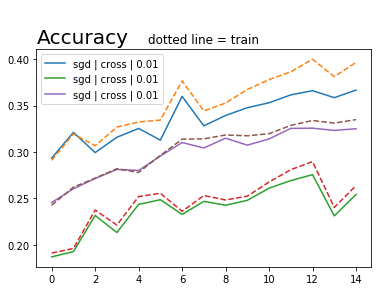

In [15]:
plt.title("\nAccuracy", fontsize=20, loc="left")
plt.title("dotted line = train")
for models in trained_models:
  plt.plot(models["Acc"], label=models["Name"])
  plt.plot(models["Train Acc"],"--") 
  print(models["Arc"],"\n",models["Name"], "| ACC: ", np.mean(models["Acc"]),"\n")

plt.legend(loc='best')
plt.show
